# Orientation to Earthdata Cloud Access

**Tutorial Lead:** Anna Windle (NASA, SSAI)

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

[edl]: https://urs.earthdata.nasa.gov/

## Summary

In this example we will use the `earthaccess` package to search for
OCI products on NASA Earthdata. The `earthaccess` package, published
on the [Python Package Index][pypi] and [conda-forge][conda],
facilitates discovery and use of all NASA Earth Science data
products by providing an abstraction layer for NASA’s [Common
Metadata Repository (CMR) API][cmr] and by simplifying requests to
NASA's [Earthdata Cloud][edcloud]. Searching for data is more
approachable using `earthaccess` than low-level HTTP requests, and
the same goes for S3 requests.

In short, `earthaccess` helps **authenticate** with an Earthdata Login,
makes **search** easier, and provides a stream-lined way to **load
data** into `xarray` containers. For more on `earthaccess`, visit
the [documentation][earthaccess-docs] site. Be aware that
`earthaccess` is under active development.

To understand the discussions below on downloading and opening data,
we need to clearly understand **where our notebook is
running**. There are three cases to distinguish:

1. The notebook is running on the local host. For instance, you started a Jupyter server on your laptop.
1. The notebook is running on a remote host, but it does not have direct access to the AWS us-west-2 region. For instance, you are running in [GitHub Codespaces][codespaces], which is run on Microsoft Azure. 
1. The notebook is running on a remote host that does have direct access to the NASA Earthdata Cloud (AWS us-west-2 region). This is the case for the PACE Hackweek. 

[pypi]: https://pypi.org/
[conda]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci-data-access/
[cmr]: https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr
[edcloud]: https://www.earthdata.nasa.gov/eosdis/cloud-evolution
[earthaccess-docs]: https://earthaccess.readthedocs.io/en/latest/
[codespaces]: https://github.com/features/codespaces

## Learning Objectives

At the end of this notebook you will know:

* How to store your NASA Earthdata Login credentials with `earthaccess`
* How to use `earthaccess` to search for OCI data using search filters
* How to download OCI data, but only when you need to

## Contents

1. [Setup](#1.-Setup)
2. [NASA Earthdata Authentication](#2.-NASA-Earthdata-Authentication)
3. [Search for Data](#3.-Search-for-Data)
4. [Open Data](#4.-Open-Data)
5. [Download Data](#5.-Download-Data)

## 1. Setup

We begin by importing the packages used in this notebook.

In [1]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

The last import provides a preview of the `DataTree` object. Once it is fully integrated into XArray,
the additional import won't be needed, as the function will be available as `xr.open_datree`.

[back to top](#Contents)

## 2. NASA Earthdata Authentication

Next, we authenticate using our Earthdata Login
credentials. Authentication is not needed to search publicaly
available collections in Earthdata, but is always needed to access
data. We can use the `login` method from the `earthaccess`
package. This will create an authenticated session when we provide a
valid Earthdata Login username and password. The `earthaccess`
package will search for credentials defined by **environmental
variables** or within a **.netrc** file saved in the home
directory. If credentials are not found, an interactive prompt will
allow you to input credentials.

<div class="alert alert-info" role="alert">
    
The `persist=True` argument ensures any discovered credentials are
stored in a `.netrc` file, so the argument is not necessary (but
it's also harmless) for subsequent calls to `earthaccess.login`.

</div>

In [2]:
auth = earthaccess.login(persist=True)

[back to top](#Contents)

## 3. Search for Data

Collections on NASA Earthdata are discovered with the
`search_datasets` function, which accepts an `instrument` filter as an
easy way to get started. Each of the items in the list of
collections returned has a "short-name".

In [3]:
results = earthaccess.search_datasets(instrument="oci")

In [4]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


<div class="alert alert-info" role="alert">
The short name can also be found on <a href="https://search.earthdata.nasa.gov/search?fi=SPEXone!HARP2!OCI" target="_blank"> Eartdata Search</a>, directly under the collection name, after clicking on the "i" button for a collection in any search result.
</div>

Next, we use the `search_data` function to find granules within a
collection. Let's use the `short_name` for the PACE/OCI Level-2 near real time (NRT), product for biogeochemical properties (although you can
search for granules accross collections too).



The `count` argument limits the number of granules whose metadata is returned and stored in the `results` list.

In [5]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    count=1,
)

We can refine our search by passing more parameters that describe
the spatiotemporal domain of our use case. Here, we use the
`temporal` parameter to request a date range and the `bounding_box`
parameter to request granules that intersect with a bounding box. We
can even provide a `cloud_cover` threshold to limit files that have
a lower percetnage of cloud cover. We do not provide a `count`, so
we'll get all granules that satisfy the constraints.

In [6]:
tspan = ("2024-07-01", "2024-07-31")
bbox = (-76.75, 36.97, -75.74, 39.01)
clouds = (0, 50)

In [7]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

Displaying results shows the direct download link: try it! The
link will download one granule to your local machine, which may or
may not be what you want to do. Even if you are running the notebook
on a remote host, this download link will open a new browser tab or
window and offer to save a file to your local machine. If you are
running the notebook locally, this may be of use. However, in the
next section we'll see how to download all the results with one
command.

In [8]:
results[0]

Collection: {'Version': '2.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 48.76455, 'Longitude': -65.21011}, {'Latitude': 42.73136, 'Longitude': -99.13216}, {'Latitude': 25.62299, 'Longitude': -90.67664}, {'Latitude': 30.94663, 'Longitude': -63.8876}, {'Latitude': 48.76455, 'Longitude': -65.21011}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-07-01T17:51:12Z', 'EndingDateTime': '2024-07-01T17:56:11Z'}}
Size(MB): 12.033413887023926
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701T175112.L2.OC_BGC.V2_0.NRT.nc']

In [9]:
results[1]

Collection: {'Version': '2.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 47.56521, 'Longitude': -53.56926}, {'Latitude': 41.60015, 'Longitude': -86.82033}, {'Latitude': 24.44016, 'Longitude': -78.64732}, {'Latitude': 29.73774, 'Longitude': -52.15326}, {'Latitude': 47.56521, 'Longitude': -53.56926}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-07-11T17:09:27Z', 'BeginningDateTime': '2024-07-11T17:04:28Z'}}
Size(MB): 20.401991844177246
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240711T170428.L2.OC_BGC.V2_0.NRT.nc']

In [10]:
results[2]

Collection: {'ShortName': 'PACE_OCI_L2_BGC_NRT', 'Version': '2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 46.93914, 'Longitude': -63.63996}, {'Latitude': 41.0118, 'Longitude': -96.54176}, {'Latitude': 23.82419, 'Longitude': -88.52211}, {'Latitude': 29.1075, 'Longitude': -62.17318}, {'Latitude': 46.93914, 'Longitude': -63.63996}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-07-15T17:49:39Z', 'BeginningDateTime': '2024-07-15T17:44:40Z'}}
Size(MB): 14.430459022521973
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240715T174440.L2.OC_BGC.V2_0.NRT.nc']

[back to top](#Contents)

## 4. Open L2 Data

Let's go ahead and open a couple granules using `xarray`. The `earthaccess.open` function is used when you want to directly read bytes from a remote filesystem, but not download a whole file. When
running code on a host with direct access to the NASA Earthdata
Cloud, you don't need to download the data and `earthaccess.open`
is the way to go.

In [11]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

The `paths` list contains references to files on a remote filesystem. The ob-cumulus-prod-public is the S3 Bucket in AWS us-west-2 region.

In [12]:
paths

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240701T175112.L2.OC_BGC.V2_0.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240711T170428.L2.OC_BGC.V2_0.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240715T174440.L2.OC_BGC.V2_0.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240716T164059.L2.OC_BGC.V2_0.NRT.nc>]

In [13]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20240701T175112.L2.OC_BGC.V2_...
    processing_version:                2.0
    history:                           l2gen par=/data6/sdpsoper/vdc/vpu5/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -63.887604
    geospatial_lon_min:                -99.13216
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9674437642097473

Notice that this `xarray.Dataset` has nothing but "Attributes". The NetCDF data model includes multi-group hierarchies within a single file, where each group maps to an `xarray.Dataset`. The whole file maps to a `DataTree`, which we will only use lightly because the implementation in XArray remains under development.

In [14]:
datatree = open_datatree(paths[0])
datatree

<xarray.DataTree>
Group: /
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes: (12/45)
│       title:                             OCI Level-2 Data BGC
│       product_name:                      PACE_OCI.20240701T175112.L2.OC_BGC.V2_...
│       processing_version:                2.0
│       history:                           l2gen par=/data6/sdpsoper/vdc/vpu5/wor...
│       instrument:                        OCI
│       platform:                          PACE
│       ...                                ...
│       geospatial_lon_max:                -63.887604
│       geospatial_lon_min:                -99.13216
│       startDirection:                    Ascending
│       endDirection:                      Ascending
│       day_night_flag:                    Day
│       earth_sun_distance_correction:     0.9674437642097473
├── Group: /sensor_band_parameters
│       Dimensions:      (number_of_bands: 286, number_of_reflective_bands: 286)
│       Dimensions without coordinates: number_of_bands, number_of_reflective_bands
│       Data variables:
│           wavelength   (number_of_bands) float64 2kB ...
│           vcal_gain    (number_of_reflective_bands) float32 1kB ...
│           vcal_offset  (number_of_reflective_bands) float32 1kB ...
│           F0           (number_of_reflective_bands) float32 1kB ...
│           aw           (number_of_reflective_bands) float32 1kB ...
│           bbw          (number_of_reflective_bands) float32 1kB ...
│           k_oz         (number_of_reflective_bands) float32 1kB ...
│           k_no2        (number_of_reflective_bands) float32 1kB ...
│           Tau_r        (number_of_reflective_bands) float32 1kB ...
├── Group: /scan_line_attributes
│       Dimensions:  (number_of_lines: 1710)
│       Dimensions without coordinates: number_of_lines
│       Data variables:
│           year     (number_of_lines) float64 14kB ...
│           day      (number_of_lines) timedelta64[ns] 14kB ...
│           msec     (number_of_lines) timedelta64[ns] 14kB ...
│           detnum   (number_of_lines) float32 7kB ...
│           mside    (number_of_lines) float32 7kB ...
│           slon     (number_of_lines) float32 7kB ...
│           clon     (number_of_lines) float32 7kB ...
│           elon     (number_of_lines) float32 7kB ...
│           slat     (number_of_lines) float32 7kB ...
│           clat     (number_of_lines) float32 7kB ...
│           elat     (number_of_lines) float32 7kB ...
│           csol_z   (number_of_lines) float32 7kB ...
├── Group: /geophysical_data
│       Dimensions:           (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           chlor_a           (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB ...
│           poc               (number_of_lines, pixels_per_line) float32 9MB ...
│           chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
│           l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
├── Group: /navigation_data
│       Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           longitude  (number_of_lines, pixels_per_line) float32 9MB ...
│           latitude   (number_of_lines, pixels_per_line) float32 9MB ...
│           tilt       (number_of_lines) float32 7kB ...
│       Attributes:
│           gringpointlongitude:  [-90.67664  -63.887604 -65.21011  -99.13216 ]
│           gringpointlatitude:   [25.622993 30.946634 48.76455  42.731358]
│           gringpointsequence:   [1 2 3 4]
└── Group: /processing_control
    │   Dimensions:  ()
    │   Data variables:
    │       *empty*
    │   Attributes:
    │       software_name:     l2gen
    │

In [15]:
dataset = xr.merge(datatree.to_dict().values())
dataset

<xarray.Dataset> Size: 70MB
Dimensions:           (number_of_bands: 286, number_of_reflective_bands: 286,
                       number_of_lines: 1710, pixels_per_line: 1272)
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength        (number_of_bands) float64 2kB ...
    vcal_gain         (number_of_reflective_bands) float32 1kB ...
    vcal_offset       (number_of_reflective_bands) float32 1kB ...
    F0                (number_of_reflective_bands) float32 1kB ...
    aw                (number_of_reflective_bands) float32 1kB ...
    bbw               (number_of_reflective_bands) float32 1kB ...
    ...                ...
    chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
    carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
    longitude         (number_of_lines, pixels_per_line) float32 9MB ...
    latitude          (number_of_lines, pixels_per_line) float32 9MB ...
    tilt              (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20240701T175112.L2.OC_BGC.V2_...
    processing_version:                2.0
    history:                           l2gen par=/data6/sdpsoper/vdc/vpu5/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -63.887604
    geospatial_lon_min:                -99.13216
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9674437642097473

Let's do a quick plot of the `chlor_a` variable. 

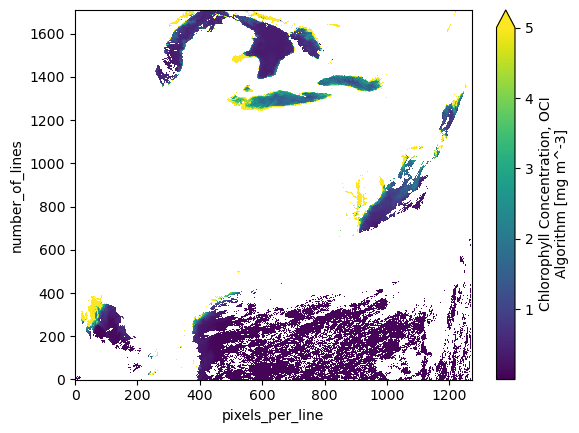

In [16]:
artist = dataset["chlor_a"].plot(vmax=5)

Let's plot with latitude and longitude so we can project the data onto a grid.

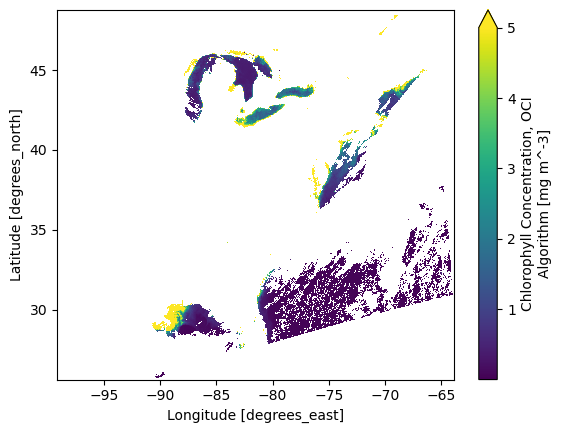

In [17]:
dataset = dataset.set_coords(("longitude", "latitude"))
plot = dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="viridis", vmax=5)

And if we want to get fancy, we can add the coastline.

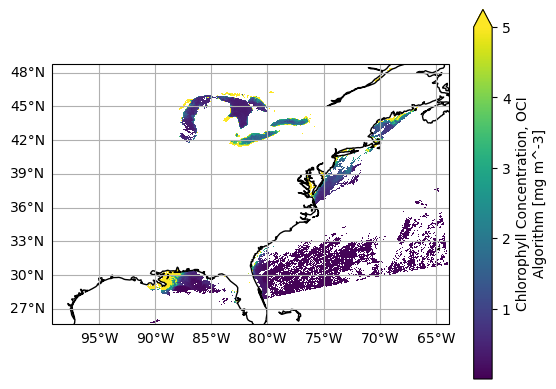

In [18]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="viridis", vmax=5, ax=ax)

[back to top](#Contents)

## 5. Open L3M Data

Let's use `earthaccess` to open some L3 mapped chlorophyll a granules. We will use a new search filter available in earthaccess.search_data: the granule_name argument accepts strings with the "*" wildcard. We need this to distinguish daily ("DAY") from eight-day ("8D") composites, as well as to get the 0.1 degree resolution projections.

In [19]:
tspan = ("2024-04-12", "2024-04-24")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

Let's open the first file using `xarray`.

In [20]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 26MB
Dimensions:  (lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 26MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240412.L3m.DAY.CHL.V2_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/2.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         771552
    data_minimum:                      0.0069892216
    data_maximum:                      94.097694

Becuase the L3M variables have lat and lon coordinates, it's possible to stack multiple granules along a new dimension that corresponds to time. Instead of xr.open_dataset, we use xr.open_mfdataset to create a single xarray.Dataset (the "mf" in open_mfdataset stands for multiple files) from an array of paths.

The paths list is sorted temporally by default, which means the shape of the paths array specifies the way we need to tile the files together into larger arrays. We specify combine="nested" to combine the files according to the shape of the array of files (or file-like objects), even though paths is not a "nested" list in this case. The concat_dim="date" argument generates a new dimension in the combined dataset, because "date" is not an existing dimension in the individual files.

In [21]:
dataset = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
dataset

<xarray.Dataset> Size: 337MB
Dimensions:  (date: 13, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 10kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240412.L3m.DAY.CHL.V2_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/2.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         771552
    data_minimum:                      0.0069892216
    data_maximum:                      94.097694

A common reason to generate a single dataset from multiple, daily images is to create a composite. Compare the map from a single day ...

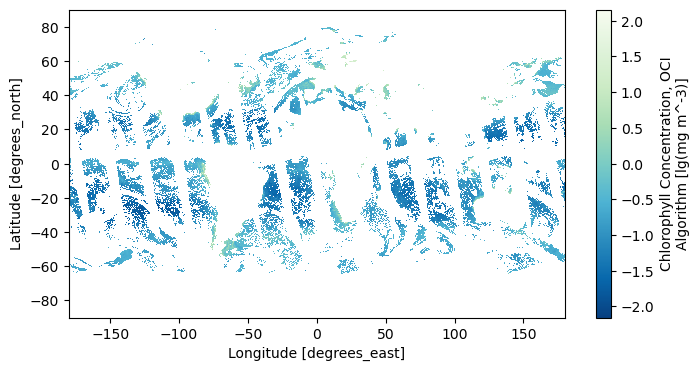

In [22]:
chla = np.log10(dataset["chlor_a"])
chla.attrs.update(
    {
        "units": f'lg({dataset["chlor_a"].attrs["units"]})',
    }
)
plot = chla.sel({"date": 0}).plot(aspect=2, size=4, cmap="GnBu_r")

... to a map of average values, skipping "NaN" values that result from clouds.

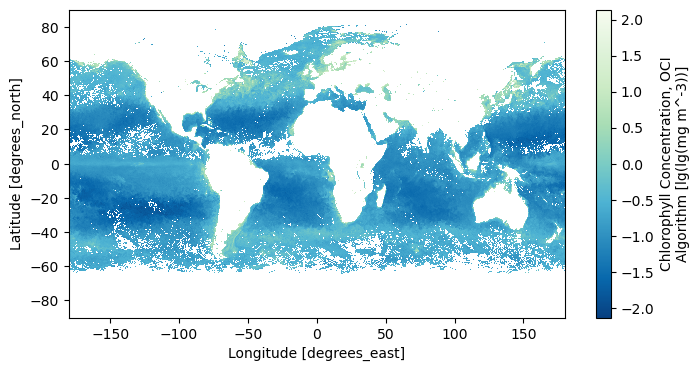

In [23]:
chla_avg = chla.mean("date")
chla_avg.attrs.update(
    {
        "long_name": chla.attrs["long_name"],
        "units": f'lg({chla.attrs["units"]})',
    }
)
plot = chla_avg.plot(aspect=2, size=4, cmap="GnBu_r")

## 6. Download Data

Let's go ahead and download a couple granules. 

Let's look at the `earthaccess.download` function, which is used
to copy files onto a filesystem local to the machine executing the
code. For this function, provide the output of
`earthaccess.search_data` along with a directory where `earthaccess` will store downloaded granules.

Even if you only want to read a slice of the data, and downloading
seems unncessary, if you use `earthaccess.open` while not running on a remote host with direct access to the NASA Earthdata Cloud,
performance will be very poor. This is not a problem with "the
cloud" or with `earthaccess`, it has to do with the data format and may soon be resolved.


In [24]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

The `paths` list now contains paths to actual files on the local
filesystem.

In [25]:
paths = earthaccess.download(results, local_path="data")
paths

[PosixPath('data/PACE_OCI.20240413T175656.L2.OC_BGC.V2_0.NRT.nc'),
 PosixPath('data/PACE_OCI.20240414T183158.L2.OC_BGC.V2_0.NRT.nc'),
 PosixPath('data/PACE_OCI.20240419T180521.L2.OC_BGC.V2_0.NRT.nc'),
 PosixPath('data/PACE_OCI.20240422T181158.L2.OC_BGC.V2_0.NRT.nc'),
 PosixPath('data/PACE_OCI.20240424T174337.L2.OC_BGC.V2_0.NRT.nc')]

We can open up that locally saved file using `xarray` as well.

In [26]:
open_datatree(paths[0])

<xarray.DataTree>
Group: /
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes: (12/45)
│       title:                             OCI Level-2 Data BGC
│       product_name:                      PACE_OCI.20240413T175656.L2.OC_BGC.V2_...
│       processing_version:                2.0
│       history:                           l2gen par=/data2/sdpsoper/vdc/vpu21/wo...
│       instrument:                        OCI
│       platform:                          PACE
│       ...                                ...
│       geospatial_lon_max:                -65.40468
│       geospatial_lon_min:                -103.36526
│       startDirection:                    Ascending
│       endDirection:                      Ascending
│       day_night_flag:                    Day
│       earth_sun_distance_correction:     0.9942150712013245
├── Group: /sensor_band_parameters
│       Dimensions:      (number_of_bands: 286, number_of_reflective_bands: 286)
│       Dimensions without coordinates: number_of_bands, number_of_reflective_bands
│       Data variables:
│           wavelength   (number_of_bands) float64 2kB ...
│           vcal_gain    (number_of_reflective_bands) float32 1kB ...
│           vcal_offset  (number_of_reflective_bands) float32 1kB ...
│           F0           (number_of_reflective_bands) float32 1kB ...
│           aw           (number_of_reflective_bands) float32 1kB ...
│           bbw          (number_of_reflective_bands) float32 1kB ...
│           k_oz         (number_of_reflective_bands) float32 1kB ...
│           k_no2        (number_of_reflective_bands) float32 1kB ...
│           Tau_r        (number_of_reflective_bands) float32 1kB ...
├── Group: /scan_line_attributes
│       Dimensions:  (number_of_lines: 1710)
│       Dimensions without coordinates: number_of_lines
│       Data variables:
│           year     (number_of_lines) float64 14kB ...
│           day      (number_of_lines) timedelta64[ns] 14kB ...
│           msec     (number_of_lines) timedelta64[ns] 14kB ...
│           detnum   (number_of_lines) float32 7kB ...
│           mside    (number_of_lines) float32 7kB ...
│           slon     (number_of_lines) float32 7kB ...
│           clon     (number_of_lines) float32 7kB ...
│           elon     (number_of_lines) float32 7kB ...
│           slat     (number_of_lines) float32 7kB ...
│           clat     (number_of_lines) float32 7kB ...
│           elat     (number_of_lines) float32 7kB ...
│           csol_z   (number_of_lines) float32 7kB ...
├── Group: /geophysical_data
│       Dimensions:           (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           chlor_a           (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB ...
│           poc               (number_of_lines, pixels_per_line) float32 9MB ...
│           chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
│           l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
├── Group: /navigation_data
│       Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           longitude  (number_of_lines, pixels_per_line) float32 9MB ...
│           latitude   (number_of_lines, pixels_per_line) float32 9MB ...
│           tilt       (number_of_lines) float32 7kB ...
│       Attributes:
│           gringpointlongitude:  [ -93.578735  -65.40468   -66.24995  -103.36526 ]
│           gringpointlatitude:   [30.214327 35.672337 53.449913 47.069923]
│           gringpointsequence:   [1 2 3 4]
└── Group: /processing_control
    │   Dimensions:  ()
    │   Data variables:
    │       *empty*
    │   Attributes:
    │       software_name:     l2gen
 

[back to top](#Contents)